<a href="https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/toxicity_simple_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity comments classification with simple transformers

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data

In [0]:
!unzip "/content/drive/My Drive/toxic-comment-classification-challenge.zip" -d ./data

Archive:  /content/drive/My Drive/toxic-comment-classification-challenge.zip
  inflating: ./data/test_labels.csv  
  inflating: ./data/sample_submission.csv  
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [0]:
DATA_PATH = "/content/data/"

In [0]:
!ls -l $DATA_PATH

total 137136
-rw-r--r-- 1 root root  6279782 Jun 19  2018 sample_submission.csv
-rw-r--r-- 1 root root 60354593 Jun 19  2018 test.csv
-rw-r--r-- 1 root root  4976930 Jun 19  2018 test_labels.csv
-rw-r--r-- 1 root root 68802655 Jun 19  2018 train.csv


In [0]:
!pip install transformers
!pip install seqeval
!pip install tensorboardx
!pip install simpletransformers

     |████████████████████████████████| 317kB 9.7MB/s 
     |████████████████████████████████| 1.0MB 38.0MB/s 
     |████████████████████████████████| 645kB 57.0MB/s 
     |████████████████████████████████| 860kB 61.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=0da932d0862d9f644147e802ebf276d903594a9dbe71d99a795da459d952af63
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e5509de4d55c1e7dcf23077e975f8bcb3fa0706d2aab4f72821f22081822d927
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
     |████████████████████████████████| 194kB 9.0MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 


In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel


In [0]:
df = pd.read_csv(DATA_PATH + 'train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [0]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [0]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
print(np.sum(df['toxic'] > 0),
np.sum(df['severe_toxic'] > 0),
np.sum(df['obscene'] > 0),
np.sum(df['threat'] > 0),
np.sum(df['insult'] > 0),
np.sum(df['identity_hate'] > 0))

15294 1595 8449 478 7877 1405


In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

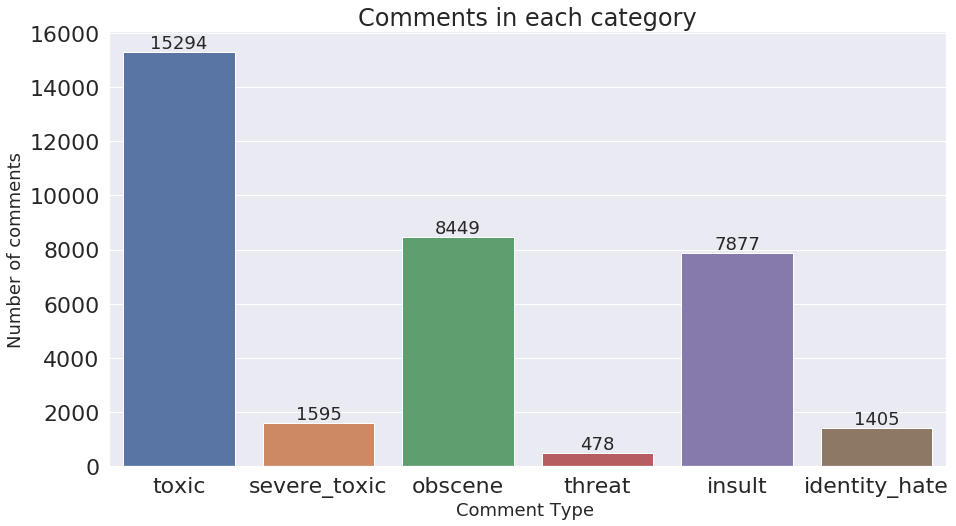

In [0]:
%matplotlib inline

df2 = df[['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
categories = list(df2.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, df2.sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = df2.sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

In [0]:
df['labels'] = list(zip(df.toxic.tolist(), df.severe_toxic.tolist(), df.obscene.tolist(), df.threat.tolist(),  df.insult.tolist(), df.identity_hate.tolist()))
df['text'] = df['comment_text'].apply(lambda x: x.replace('\n', ' '))

df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels,text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",Explanation Why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)","Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",""" More I can't make any real suggestions on im..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)","You, sir, are my hero. Any chance you remember..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",""" Congratulations from me as well, use the to..."
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,"(1, 1, 1, 0, 1, 0)",COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",Your vandalism to the Matt Shirvington article...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",Sorry if the word 'nonsense' was offensive to ...
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,"(0, 0, 0, 0, 0, 0)",alignment on this subject and which are contra...


In [0]:
train_df, eval_df = train_test_split(df, test_size=0.2)

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install -U tensorboard >piplog 2>&1

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
LABELS = 6
BATCH_SIZE = 2
TRAIN_EPOCHS = 3
MAX_SEQ_LEN = 512

In [0]:
model = MultiLabelClassificationModel('roberta', 'roberta-base', num_labels=LABELS, args={'train_batch_size':BATCH_SIZE, 'gradient_accumulation_steps':16, 'learning_rate': 3e-5, 'num_train_epochs': TRAIN_EPOCHS, 'max_seq_length': MAX_SEQ_LEN})

100%|██████████| 501200538/501200538 [00:17<00:00, 28348011.20B/s]


In [0]:
%time model.train_model(train_df)

Features loaded from cache at cache_dir/cached_train_roberta_512_binary


Running loss: 0.039481

Running loss: 0.009909

Running loss: 0.300623Training of roberta model complete. Saved to outputs/.
CPU times: user 5h 22min 5s, sys: 2h 6min 1s, total: 7h 28min 6s
Wall time: 7h 35min 59s


In [0]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

Converting to features started.


In [0]:
result

{'LRAP': 0.9963951729420162, 'eval_loss': 0.038346445133354785}

In [0]:
model_outputs

array([[3.52941424e-04, 1.01941114e-04, 1.35820534e-04, 7.63346252e-05,
        1.63937031e-04, 9.23321568e-05],
       [3.01254448e-04, 1.16612813e-04, 1.33582318e-04, 8.97430655e-05,
        1.74120461e-04, 1.06487845e-04],
       [2.96371902e-04, 1.16844225e-04, 1.41191864e-04, 8.92457974e-05,
        1.76046960e-04, 1.05648862e-04],
       ...,
       [3.19540966e-04, 1.10628374e-04, 1.38251984e-04, 8.37866028e-05,
        1.65511461e-04, 1.00111247e-04],
       [2.87870498e-04, 1.23055361e-04, 1.38322663e-04, 9.39216261e-05,
        1.75944762e-04, 1.07437940e-04],
       [2.89761927e-04, 1.21842553e-04, 1.42827907e-04, 9.19385566e-05,
        1.74931396e-04, 1.05993269e-04]], dtype=float32)

In [0]:
wrong_predictions

In [0]:
test_df = pd.read_csv(DATA_PATH + 'test.csv')

In [0]:
to_predict = test_df.comment_text.apply(lambda x: x.replace('\n', ' ')).tolist()

In [0]:
preds, outputs = model.predict(to_predict)

Converting to features started.


In [0]:
preds

In [0]:
sub_df = pd.DataFrame(outputs, columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])

In [0]:
sub_df['id'] = test_df['id']
sub_df = sub_df[['id', 'toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [0]:
sub_df.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.997462,0.324958,0.989660,0.086769,0.969285,0.521797
1,0000247867823ef7,0.000332,0.000106,0.000138,0.000080,0.000166,0.000096
2,00013b17ad220c46,0.000337,0.000107,0.000144,0.000079,0.000162,0.000093
3,00017563c3f7919a,0.000285,0.000124,0.000144,0.000092,0.000178,0.000109
4,00017695ad8997eb,0.000359,0.000106,0.000122,0.000084,0.000161,0.000099


In [0]:
sub_df.to_csv('./submission.csv', index=False)

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions submit -c jigsaw-toxic-comment-classification-challenge -f submission.csv -m "My first submission"

100% 13.9M/13.9M [00:04<00:00, 3.12MB/s]
Successfully submitted to Toxic Comment Classification Challenge